02/10/2023

## Imports

In [5]:
%%time

import numpy as np
from numpy import random
from numpy.matlib import repmat
from scipy.optimize import curve_fit
from scipy.stats import skewnorm
import scipy
import uproot
import awkward as ak
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl
import glob
import os
import importlib
import sys
sys.path.append('.')
import MiXHelper

ts = 25
params = {'legend.fontsize': 'large',
          'font.family': 'serif',
          'figure.figsize': (13,9),
          'axes.labelsize': ts,
          'axes.titlesize': ts,
          'xtick.labelsize': ts,
          'ytick.labelsize': ts}
plt.rcParams.update(params)

CPU times: user 699 ms, sys: 193 ms, total: 892 ms
Wall time: 30.4 s


In [6]:
importlib.reload(MiXHelper)

<module 'MiXHelper' from '/home/samaraa/Calibrations/MiXHelper.py'>

## Unit Conversions

In [7]:
adcTomV = 2.25/2**14*1000
areaToGain = 2.25/2**14/50/10**8/1.6e-19

The bPMT plots looked good without amplification and using simple summing, so they were not redone like the tPMTs. The tPMTs are with 10x (linear) amplification and trapezoidal summing for the area.

## bPMT 1700V

### Visualization

In [4]:
%%time

filePath = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/MiXData/20230210/LED_100ns_1040mV_tPMTx4_850V_bPMT_1700V_run2/'
fileNames = sorted(filter(os.path.isfile, glob.glob(filePath + '*.root')))

root_file = uproot.open(fileNames[0])
bPMT = root_file['Channel4/ADCValues'].array()
adj_bPMT = bPMT - np.average(np.array(bPMT[:, 0:100]), axis = 1)
merged_bPMT = np.average(np.array(adj_bPMT), axis = 0)

CPU times: user 792 ms, sys: 532 ms, total: 1.32 s
Wall time: 2.64 s


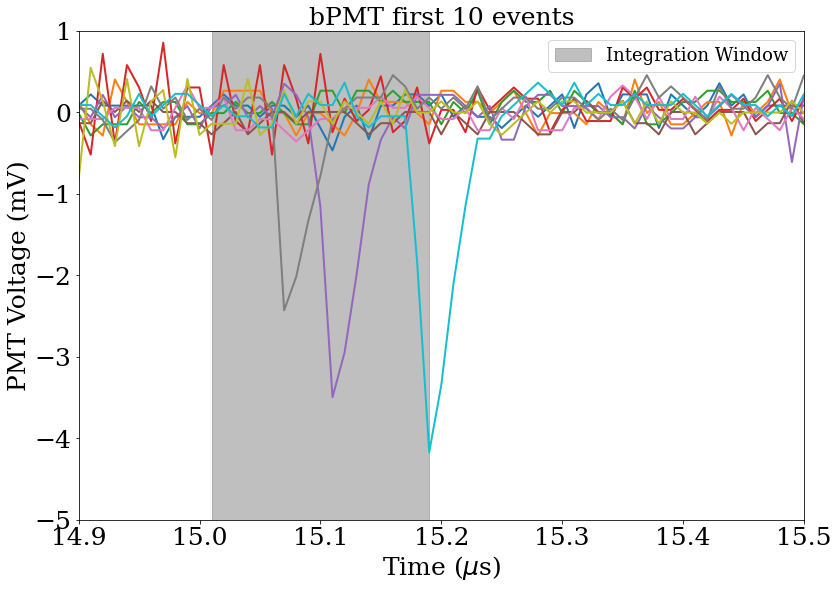

CPU times: user 313 ms, sys: 8.73 ms, total: 321 ms
Wall time: 510 ms


In [5]:
%%time

plt.figure()
for i in range(0,10):
    plt.plot(np.arange(0, 3000, 1)/100, adj_bPMT[i]*adcTomV, linewidth = 2)
    #, label = 'Averaged Waveform'
rect = Rectangle((15.01, -20), 0.18, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 1])
plt.legend(fontsize = 18)
plt.title("bPMT first 10 events")
plt.show()

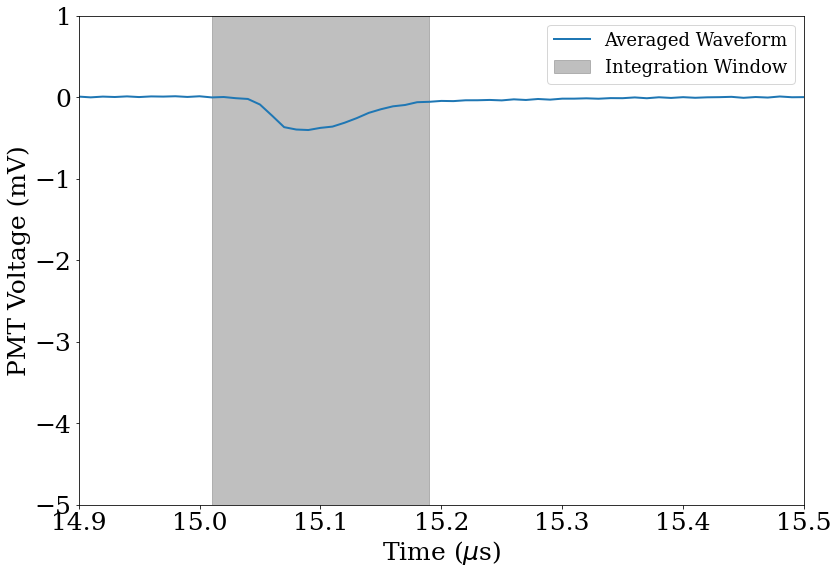

CPU times: user 125 ms, sys: 982 µs, total: 126 ms
Wall time: 134 ms


In [6]:
%%time

plt.figure()
plt.plot(np.arange(0, 3000, 1)/100, merged_bPMT*adcTomV, linewidth = 2, label = 'Averaged Waveform')
rect = Rectangle((15.01, -20), 0.18, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 1])
plt.legend(fontsize = 18)
plt.show()

### Analysis

In [7]:
%%time

start, stop, channel = 1501, 1519, 4
areas_bPMT, heights_bPMT, offsets_bPMT = MiXHelper.LED_simple(fileNames, start, stop, channel)

areas_bPMT = np.array(areas_bPMT)
heights_bPMT = np.array(heights_bPMT)
offsets_bPMT = np.array(offsets_bPMT)

CPU times: user 1min 36s, sys: 21.4 s, total: 1min 58s
Wall time: 3min 25s


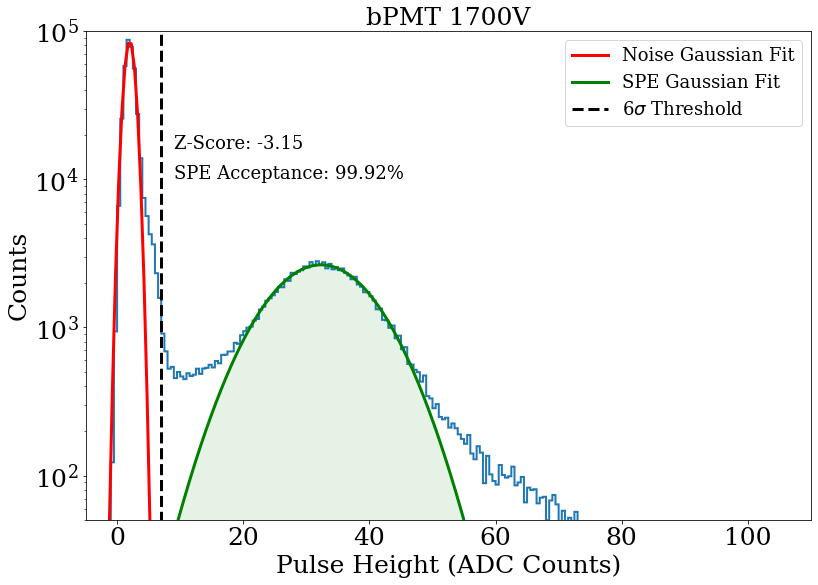

In [8]:
height_n, height_raw_bins, patches = plt.hist(heights_bPMT, bins = np.arange(-55, 250, 0.5), histtype = 'step', log = True, linewidth = 2)
height_bins = height_raw_bins[:-1]

x = height_bins[(height_bins >= 0) & (height_bins <= 5)] + 0.5/2
y = height_n[(height_bins >= 0) & (height_bins <= 5)]
p0 = [1e4, 0, 20]
coeff, var_matrix = curve_fit(MiXHelper.gaussian, x, y, p0=p0)
cut_pos = np.abs(6*coeff[2]) + coeff[1]
hist_fit = MiXHelper.gaussian(height_bins + 0.5/2, *coeff)
plt.plot(height_bins + 0.5/2, hist_fit, color = 'r', linewidth = 3, label = 'Noise Gaussian Fit')

x2 = height_bins[(height_bins >= 25) & (height_bins <= 50)] + 0.5/2
y2 = height_n[(height_bins >= 25) & (height_bins <= 50)]
p2 = [1e3, 40, 2]
coeff2, var_matrix2 = curve_fit(MiXHelper.gaussian, x2, y2, p0=p2)
x_fit2 = np.arange(0, 90, 0.1)
hist_fit2 = MiXHelper.gaussian(x_fit2, *coeff2)
plt.plot(x_fit2, hist_fit2, color = 'g', linewidth = 3, label = 'SPE Gaussian Fit')
plt.fill_between(x_fit2[x_fit2 >= cut_pos], hist_fit2[x_fit2 >= cut_pos], color = 'green', alpha = 0.1)

zScore = (cut_pos - coeff2[1])/coeff2[2]
prob = 1 - scipy.stats.norm.cdf(zScore)
plt.text(cut_pos + 2, 1.6e4, 'Z-Score: ' + str(round(zScore, 2)), fontsize = 18)
plt.text(cut_pos + 2, 1e4, 'SPE Acceptance: ' + str(round(prob*100, 2)) + '%', fontsize = 18)

plt.plot([cut_pos, cut_pos], [1, 1e5], 'k--', linewidth = 3, label = '6$\sigma$ Threshold')

plt.xlim([-5, 110]) #55
plt.ylim([5e1, 1e5])
plt.xlabel('Pulse Height (ADC Counts)')
plt.ylabel('Counts')
plt.title('bPMT 1700V')
plt.legend(fontsize = 18)
plt.show()

In [9]:
coeff2

array([2645.13575435,   32.32424157,    8.04570372])

/home/samaraa/.conda/envs/mix/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


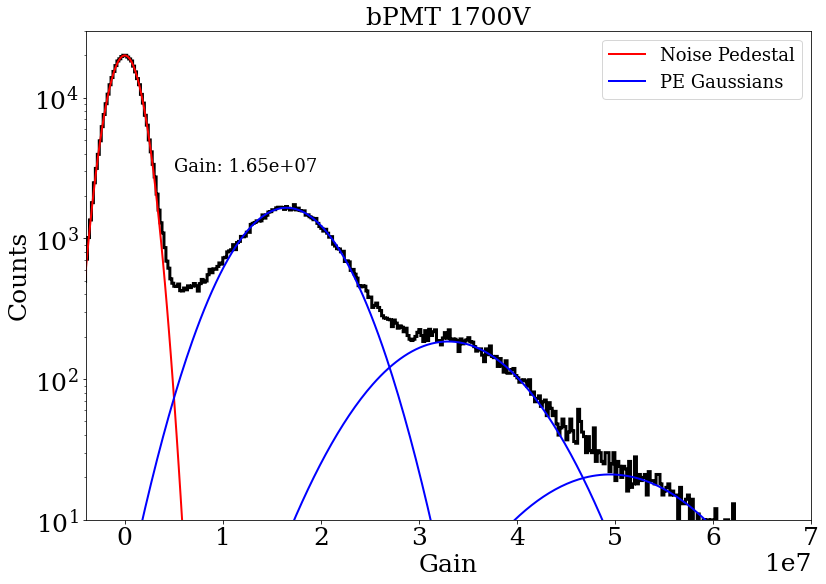

In [14]:
gains_bPMT = np.array(areas_bPMT)*areaToGain # /10
n_bPMT, raw_bins_bPMT, patches = plt.hist(gains_bPMT, bins = np.arange(-1e7, 1e8, 2e5), histtype = 'step', color = 'k', log = True, linewidth = 3)

bins_bPMT = raw_bins_bPMT[:-1] + (2e5)/2
x = bins_bPMT[(bins_bPMT > -3e6) & (bins_bPMT <= 3e7)]
y = n_bPMT[(bins_bPMT > -3e6) & (bins_bPMT <= 3e7)]

#     mu0 mu1    sigma0 sigma1 A0 A1      A2      A3
p0 = [0, 1.65e7, 1.5e6, 4.6e6, 2e4, 1.65e3, 1.85e2, 2.1e1]
#not sure why we do it this way, which doesn't match what gaussian_4 says
#if I try to rearrage and do it the way that makes sense, it gives some negative coefficients
coeff, var_matrix = curve_fit(MiXHelper.gaussian_4, x, y, p0 = p0, maxfev = 10000)

x_0 = bins_bPMT[(bins_bPMT > -5e6) & (bins_bPMT <= 10e6)]
x_1 = bins_bPMT[(bins_bPMT > -5e6) & (bins_bPMT <= 5e7)]
x_2 = bins_bPMT[(bins_bPMT > 0) & (bins_bPMT <= 6e7)]
x_3 = bins_bPMT[(bins_bPMT > 0) & (bins_bPMT <= 8e7)]

#      A,        mu,       sigma
p_0 = [coeff[4], coeff[0], coeff[2]]
p_1 = [coeff[5], coeff[1], coeff[3]]
p_2 = [coeff[6], 2*coeff[1], np.sqrt(2)*coeff[3]]
p_3 = [coeff[7], 3*coeff[1], np.sqrt(3)*coeff[3]]


plt.plot(x_0, MiXHelper.gaussian(x_0, *p_0), color = 'red', linewidth = 2, label = 'Noise Pedestal')
plt.plot(x_1, MiXHelper.gaussian(x_1, *p_1), color = 'blue', linewidth = 2, label = 'PE Gaussians')
plt.plot(x_2, MiXHelper.gaussian(x_2, *p_2), color = 'blue', linewidth = 2)
plt.plot(x_3, MiXHelper.gaussian(x_3, *p_3), color = 'blue', linewidth = 2)

combined_fit = MiXHelper.gaussian(bins_bPMT, *p_0)+MiXHelper.gaussian(bins_bPMT, *p_1)+MiXHelper.gaussian(bins_bPMT, *p_2)+MiXHelper.gaussian(bins_bPMT, *p_3)
#plt.plot(bins_bPMT,combined_fit,color = 'lime', linewidth = 3, label = 'Combined Fit')

hist_fit = MiXHelper.gaussian_4(x, *coeff)
#plt.plot(x, hist_fit, color = 'lime', linewidth = 3, label = 'Combined Fit')
gain = coeff[1] - coeff[0]
plt.text(0.5e7, 3e3, 'Gain: ' + str('{:.2e}'.format(gain)), fontsize = 18)

plt.xlim([-4e6, 7e7])
plt.ylim([1e1, 3e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('bPMT 1700V')
plt.legend(fontsize = 18)
plt.show()

In [11]:
p0, coeff

([0, 16500000.0, 1500000.0, 5000000.0, 20000.0, 1650.0, 185.0, 21.0],
 array([0.00e+00, 1.65e+07, 1.50e+06, 5.00e+06, 2.00e+04, 1.65e+03,
        1.85e+02, 2.10e+01]))

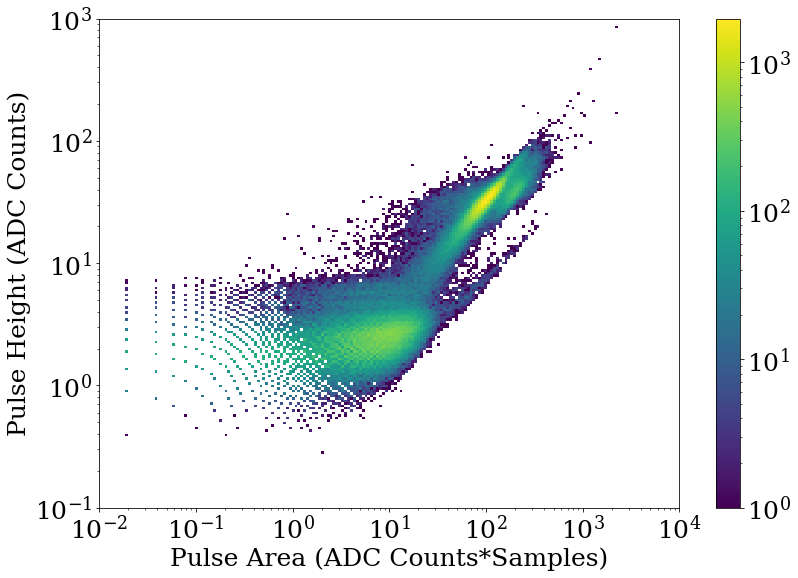

CPU times: user 754 ms, sys: 10.7 ms, total: 764 ms
Wall time: 778 ms


In [15]:
%%time

bins = 200
xbins = np.logspace(-2, 4, bins)
ybins = np.logspace(-1, 3, bins)

fig, ax = plt.subplots()
h = ax.hist2d(areas_bPMT, heights_bPMT, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Area (ADC Counts*Samples)')
plt.ylabel('Pulse Height (ADC Counts)')
fig.colorbar(h[3], ax = ax)
plt.show()

### About the new versions
Originally I was manually setting where the exponential should start. I ended up adding it to the function, so curve fit would also use that in the optimization. I used bounds to make sure it was still realistic. tPMT1 was not cooperating with the new function, so for that one the exponential start is manually decided.

[XENON1T paper with exponential](https://arxiv.org/pdf/1609.01654.pdf) page 6


[Plots from 10x amp/trapezoidal summing vs no amp/simple summing](https://docs.google.com/presentation/d/12IphxDEbPdyMlksKpgNhZtRvhyr75JQTINfqUoCYhJo/edit#slide=id.g20f5be9dbef_0_3)

## tPMT0 850V

### Visualization

In [8]:
friday1040path = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/MiXData/20230217/LED_100ns_1040mV_850x4_10xAmpTop_1136/'
friday1040names = sorted(filter(os.path.isfile, glob.glob(friday1040path + '*.root')))
friday1040file = uproot.open(friday1040names[-1])
len(friday1040names)

30

In [8]:
%%time
'''
topFilePath = '/nfs/turbo/lsa-MiXturbo/MiX-2023-data/MiXData/20230210/LED_100ns_1020mV_tPMTx4_850V_bPMT_1500V_run1/'
topFileNames = sorted(filter(os.path.isfile, glob.glob(topFilePath + '*.root')))
topRoot_file = uproot.open(topFileNames[-1])
'''
tPMT0 = friday1040file['Channel0/ADCValues'].array()
adj_tPMT0 = tPMT0 - np.average(np.array(tPMT0[:, 0:100]), axis = 1)
merged_tPMT0 = np.average(np.array(adj_tPMT0), axis = 0)

CPU times: user 829 ms, sys: 598 ms, total: 1.43 s
Wall time: 2.47 s


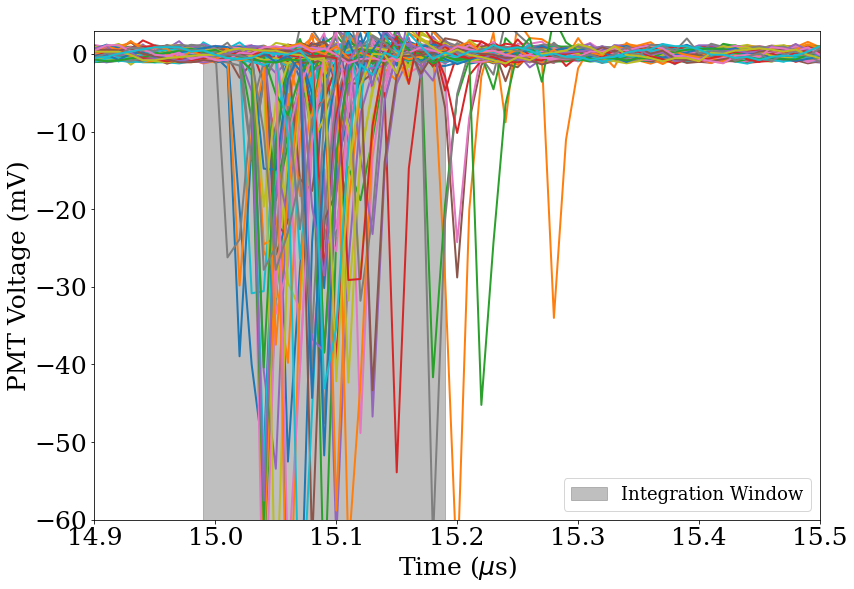

CPU times: user 726 ms, sys: 10.1 ms, total: 736 ms
Wall time: 757 ms


In [200]:
%%time

plt.figure()
for i in range(0,100):
    plt.plot(np.arange(0, 3000, 1)/100, adj_tPMT0[i]*adcTomV, linewidth = 2)
rect = Rectangle((14.99, -60), 0.20, 60, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-60, 3])
plt.legend(fontsize = 18)
plt.title("tPMT0 first 100 events")
plt.show()

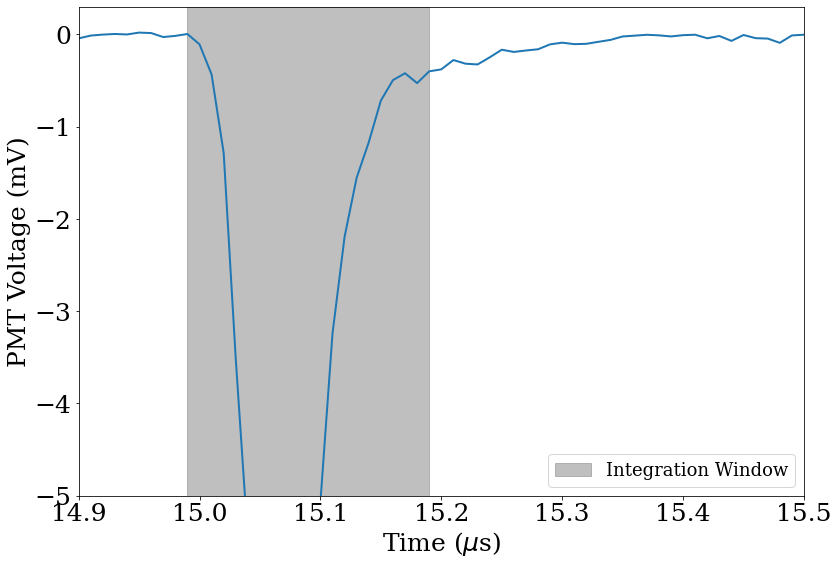

CPU times: user 127 ms, sys: 1.12 ms, total: 128 ms
Wall time: 141 ms


In [10]:
%%time

plt.figure()
plt.plot(np.arange(0, 3000, 1)/100, merged_tPMT0*adcTomV, linewidth = 2)
rect = Rectangle((14.99, -20), 0.20, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 0.3])
plt.legend(fontsize = 18)
plt.show()

### Analysis

In [9]:
def trapzArea(fileNames, start, stop, channel):
    
    areas = []
    for n in range(len(fileNames)):
        root_file = uproot.open(fileNames[n])
        
        PMT = root_file['Channel' + str(channel) + '/ADCValues'].array()
        PMT_adj = PMT - np.average(np.array(PMT[:, 0:100]), axis = 1)
        
        for i in range(len(PMT_adj)):
            total_wf = np.array(PMT_adj[i][start:stop])
            area = -1*np.trapz(total_wf)
            areas.append(area)
    
    return areas

In [13]:
def gaussian_4Exp(x, *p):
    
    A0, A1, A2, A3, mu_0, mu_1, sigma_0, sigma_1, Aexp, T = p
    
    p0 = [A0, mu_0, sigma_0]
    p1 = [A1, mu_1, sigma_1]
    p2 = [A2, 2*mu_1, np.sqrt(2)*sigma_1] # standard deviations add in quadrature
    p3 = [A3, 3*mu_1, np.sqrt(3)*sigma_1]
    
    f = MiXHelper.gaussian(x, *p0) + MiXHelper.gaussian(x, *p1) + MiXHelper.gaussian(x, *p2) + MiXHelper.gaussian(x, *p3) + Aexp*np.exp(-np.where(x > expStart, x, 0)*T)
    
    return f

In [382]:
def gaussian_4Exp_expStart(x, *p):
    
    A0, A1, A2, A3, mu_0, mu_1, sigma_0, sigma_1, Aexp, T, expStart = p
    
    p0 = [A0, mu_0, sigma_0]
    p1 = [A1, mu_1, sigma_1]
    p2 = [A2, 2*mu_1, np.sqrt(2)*sigma_1] # standard deviations add in quadrature
    p3 = [A3, 3*mu_1, np.sqrt(3)*sigma_1]
    
    f = MiXHelper.gaussian(x, *p0) + MiXHelper.gaussian(x, *p1) + MiXHelper.gaussian(x, *p2) + MiXHelper.gaussian(x, *p3) + Aexp*np.exp(-np.where(x > expStart, x, 0)*T)
    
    return f

In [371]:
%%time

start, stop, channel = 1499, 1519, 0
areas_tPMT0, heights_tPMT0, offsets_tPMT0 = MiXHelper.LED_simple(friday1040names, start, stop, channel)

areas_tPMT0 = np.array(areas_tPMT0)
heights_tPMT0 = np.array(heights_tPMT0)
offsets_tPMT0 = np.array(offsets_tPMT0)

CPU times: user 1min 10s, sys: 16.3 s, total: 1min 26s
Wall time: 2min 21s


In [372]:
%%time

trapzAreas_tPMT0 = trapzArea(friday1040names, start, stop, channel)
trapzAreas_tPMT0 = np.array(trapzAreas_tPMT0)

CPU times: user 1min 14s, sys: 16.4 s, total: 1min 30s
Wall time: 1min 33s


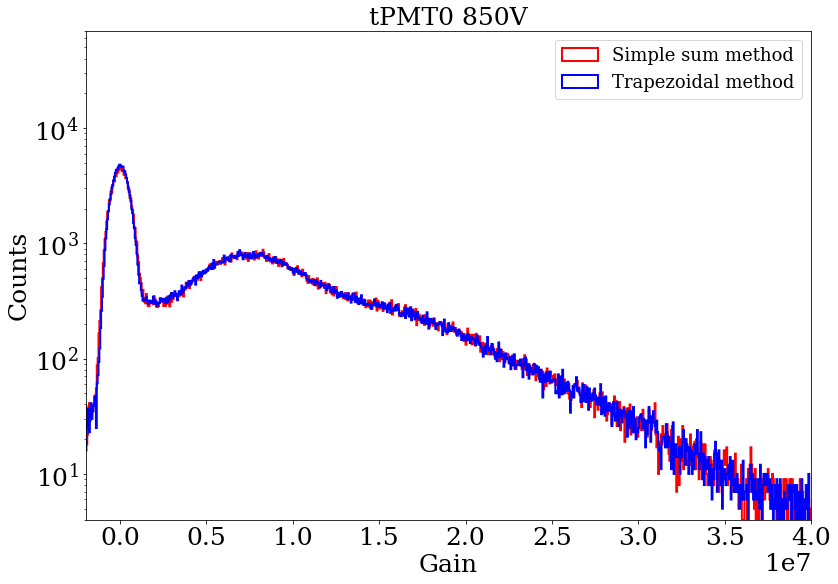

In [373]:
gains_tPMT0 = np.array(areas_tPMT0)*areaToGain / 10 #bc 10x amplified
plt.hist(gains_tPMT0, bins = np.arange(-1e7, 4e7, 0.5e5), histtype = 'step', color = 'r', log = True, linewidth = 2, label='Simple sum method')

trapzGains_tPMT0 = np.array(trapzAreas_tPMT0)*areaToGain / 10
plt.hist(trapzGains_tPMT0, bins = np.arange(-1e7, 4e7, 0.5e5), histtype = 'step', color = 'b', log = True, linewidth = 2, label='Trapezoidal method')

plt.xlim([-2e6, 4e7])
plt.ylim([0.4e1, 7e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('tPMT0 850V')
plt.legend(fontsize = 18)
plt.show()

In [41]:
%%time

diff = gains_tPMT0 - trapzGains_tPMT0

perc = []
for i in range(0, len(diff)):
    try: perc.append(100 * diff[i] / trapzGains_tPMT0[i])
    except: perc.append(0)

CPU times: user 128 ms, sys: 2.9 ms, total: 131 ms
Wall time: 138 ms


<timed exec>:5: RuntimeWarning: divide by zero encountered in double_scalars
<timed exec>:5: RuntimeWarning: invalid value encountered in double_scalars


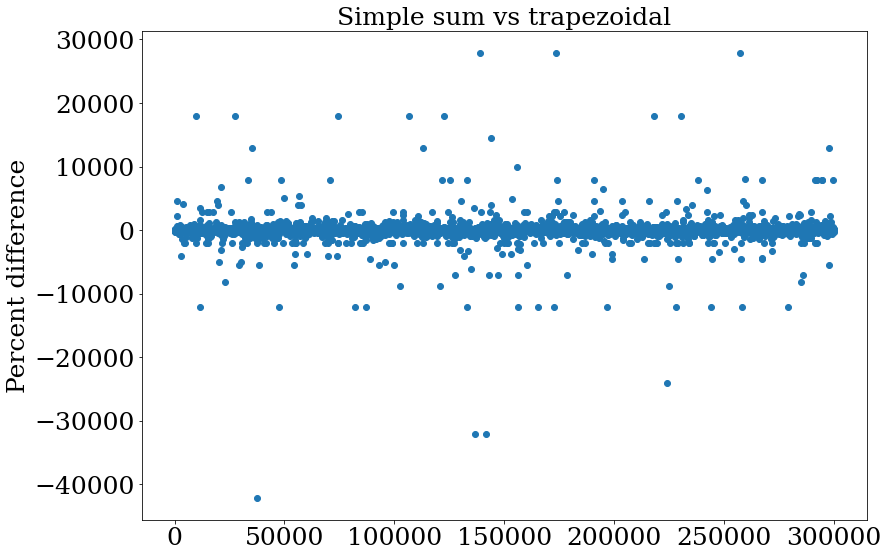

In [42]:
plt.scatter(np.arange(0, len(perc), 1), perc)
plt.title('Simple sum vs trapezoidal')
plt.ylabel('Percent difference')
plt.show()

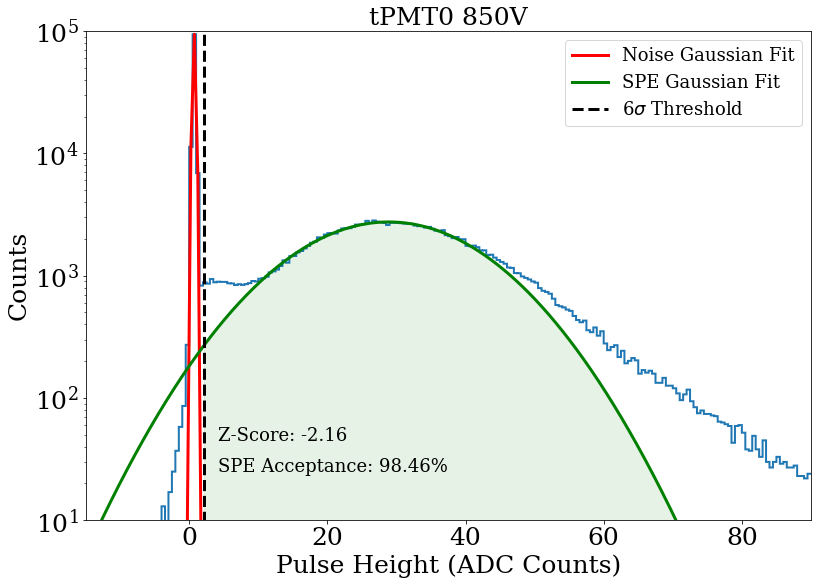

CPU times: user 491 ms, sys: 6.91 ms, total: 498 ms
Wall time: 523 ms


In [374]:
%%time

plt.figure()
height_n, height_raw_bins, patches = plt.hist(heights_tPMT0/10, bins = np.arange(-55, 250, 0.5), histtype = 'step', log = True, linewidth = 2)

height_bins = height_raw_bins[:-1]
x = height_bins[(height_bins >= 0) & (height_bins <= 5)] + 0.5/2
y = height_n[(height_bins >= 0) & (height_bins <= 5)]
p0 = [1e5, 0, 20]
coeff, var_matrix = curve_fit(MiXHelper.gaussian, x, y, p0=p0, maxfev=10000)
cut_pos = np.abs(6*coeff[2]) + coeff[1]
hist_fit = MiXHelper.gaussian(height_bins + 0.5/2, *coeff)
plt.plot(height_bins + 0.5/2, hist_fit, color = 'r', linewidth = 3, label = 'Noise Gaussian Fit')

x2 = height_bins[(height_bins >= 13) & (height_bins <= 40)] + 0.5/2
y2 = height_n[(height_bins >= 13) & (height_bins <= 40)]
p2 = [2e3, 17, 2]
coeff2, var_matrix2 = curve_fit(MiXHelper.gaussian, x2, y2, p0=p2, maxfev=10000)
x_fit2 = np.arange(-15, 80, 0.1)
hist_fit2 = MiXHelper.gaussian(x_fit2, *coeff2)
plt.plot(x_fit2, hist_fit2, color = 'g', linewidth = 3, label = 'SPE Gaussian Fit')
plt.fill_between(x_fit2[x_fit2 >= cut_pos], hist_fit2[x_fit2 >= cut_pos], color = 'green', alpha = 0.1)

zScore = (cut_pos - coeff2[1])/coeff2[2]
prob = 1 - scipy.stats.norm.cdf(zScore)
plt.text(cut_pos + 2, 4.5e1, 'Z-Score: ' + str(round(zScore, 2)), fontsize = 18)
plt.text(cut_pos + 2, 2.5e1, 'SPE Acceptance: ' + str(round(prob*100, 2)) + '%', fontsize = 18)

plt.plot([cut_pos, cut_pos], [1, 4e5], 'k--', linewidth = 3, label = '6$\sigma$ Threshold')

plt.xlim([-15, 90])
plt.ylim([1e1, 1e5])
plt.xlabel('Pulse Height (ADC Counts)')
plt.ylabel('Counts')
plt.title('tPMT0 850V')
plt.legend(fontsize = 18)
plt.show()

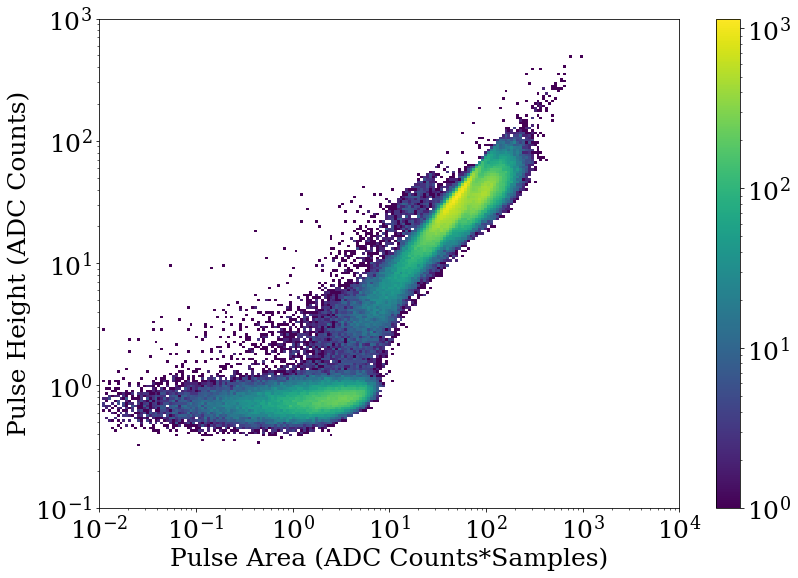

CPU times: user 862 ms, sys: 22.5 ms, total: 885 ms
Wall time: 931 ms


In [375]:
%%time

bins = 200
xbins = np.logspace(-2, 4, bins)
ybins = np.logspace(-1, 3, bins)

fig, ax = plt.subplots()
h = ax.hist2d(trapzAreas_tPMT0/10, heights_tPMT0/10, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Area (ADC Counts*Samples)')
plt.ylabel('Pulse Height (ADC Counts)')
fig.colorbar(h[3], ax = ax)
plt.show()

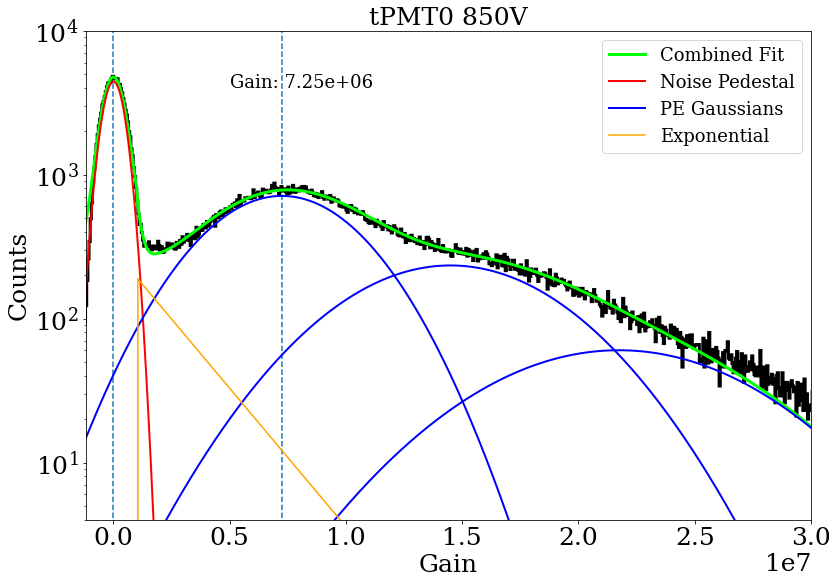

CPU times: user 613 ms, sys: 2.59 ms, total: 616 ms
Wall time: 667 ms


In [389]:
%%time

trapzGains_tPMT0 = np.array(trapzAreas_tPMT0)*areaToGain / 10 #bc 10x amplified
n_tPMT0, raw_bins_tPMT0, patches = plt.hist(trapzGains_tPMT0, bins = np.arange(-1e7, 4e7, .5e5), histtype = 'step', color = 'k', log = True, linewidth = 3)

bins_tPMT0 = raw_bins_tPMT0[:-1] + (2e5)/2 #tbh no idea what (2e5)/2 is from
x = bins_tPMT0[(bins_tPMT0 > -3e6) & (bins_tPMT0 <= 2.5e7)]
y = n_tPMT0[(bins_tPMT0 > -3e6) & (bins_tPMT0 <= 2.5e7)]
#     A0,    A1,  A2,    A3,    mu0 mu1, sigma0, sigma1, Aexp, T, expStart
p0 = [4.7e3, 8e2, 2.6e2, 6.5e1, 0, 10e6, 5e5, 3.3e6, 3e2, 1e-10, 1e6]

#bounds bc curve fit throws a fit otherwise
n = -np.inf
p = np.inf
bounds = [(n, n, n, n, -100, -10000000, n, n, 3e2, n, 7e5),
                    (p, p, p, p, 100, 10000000, p, p, 5e4, p, 2e6)]

#find optimized combined fit
coeff, var_matrix = curve_fit(gaussian_4Exp_expStart, x, y, p0 = p0, bounds = bounds, maxfev = 10000)
hist_fit = gaussian_4Exp_expStart(bins_tPMT0, *coeff)

#bins to plot individual gaussians
x_0 = bins_tPMT0[(bins_tPMT0 > -5e6) & (bins_tPMT0 <= 5e6)]
x_1 = bins_tPMT0[(bins_tPMT0 > -5e6) & (bins_tPMT0 <= 2e7)]
x_2 = bins_tPMT0[(bins_tPMT0 > 0) & (bins_tPMT0 <= 3e7)]
x_3 = bins_tPMT0[(bins_tPMT0 > 0) & (bins_tPMT0 <= 8e7)]

#parameters for individual gaussians
p_0 = [coeff[0], coeff[4], coeff[6]]
p_1 = [coeff[1], coeff[5], coeff[7]]
p_2 = [coeff[2], 2*coeff[5], np.sqrt(2)*coeff[7]]
p_3 = [coeff[3], 3*coeff[5], np.sqrt(3)*coeff[7]]

plt.plot(bins_tPMT0, hist_fit, color = 'lime', linewidth = 3, label = 'Combined Fit')
plt.plot(x_0, MiXHelper.gaussian(x_0, *p_0), color = 'red', linewidth = 2, label = 'Noise Pedestal')
plt.plot(x_1, MiXHelper.gaussian(x_1, *p_1), color = 'b', linewidth = 2, label = 'PE Gaussians')
plt.plot(x_2, MiXHelper.gaussian(x_2, *p_2), color = 'b', linewidth = 2)
plt.plot(x_3, MiXHelper.gaussian(x_3, *p_3), color = 'b', linewidth = 2)
plt.plot(bins_tPMT0, coeff[-3]*np.exp(-np.where(bins_tPMT0 > coeff[-1], bins_tPMT0, 0)*coeff[-2])*[bins_tPMT0 > coeff[-1]][0], label='Exponential', color='orange')

plt.vlines(coeff[5], 0, 1e4, linestyles='dashed')
plt.vlines(coeff[4], 0, 1e4, linestyles='dashed')

#gain = SPE mean - noise mean
gain = coeff[5] - coeff[4]
plt.text(0.5e7, 4e3, 'Gain: ' + str('{:.2e}'.format(gain)), fontsize = 18)

plt.xlim([-1.2e6, 3e7])
plt.ylim([0.4e1, 1e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('tPMT0 850V')
plt.legend(fontsize = 18)
plt.show()

In [390]:
p0, coeff

([4700.0,
  800.0,
  260.0,
  65.0,
  0,
  10000000.0,
  500000.0,
  3300000.0,
  300.0,
  1e-10,
  1000000.0],
 array([4.41789919e+03, 7.10621309e+02, 2.33706998e+02, 6.02245354e+01,
        1.00000000e+02, 7.24667095e+06, 4.60341295e+05, 3.02992664e+06,
        3.00000000e+02, 4.42873796e-07, 1.00000000e+06]))

## tPMT1 850V

### Visualization

In [200]:
%%time

tPMT1 = friday1040file['Channel1/ADCValues'].array()
adj_tPMT1 = tPMT1 - np.average(np.array(tPMT1[:, 0:100]), axis = 1)
merged_tPMT1 = np.average(np.array(adj_tPMT1), axis = 0)

CPU times: user 857 ms, sys: 585 ms, total: 1.44 s
Wall time: 2.98 s


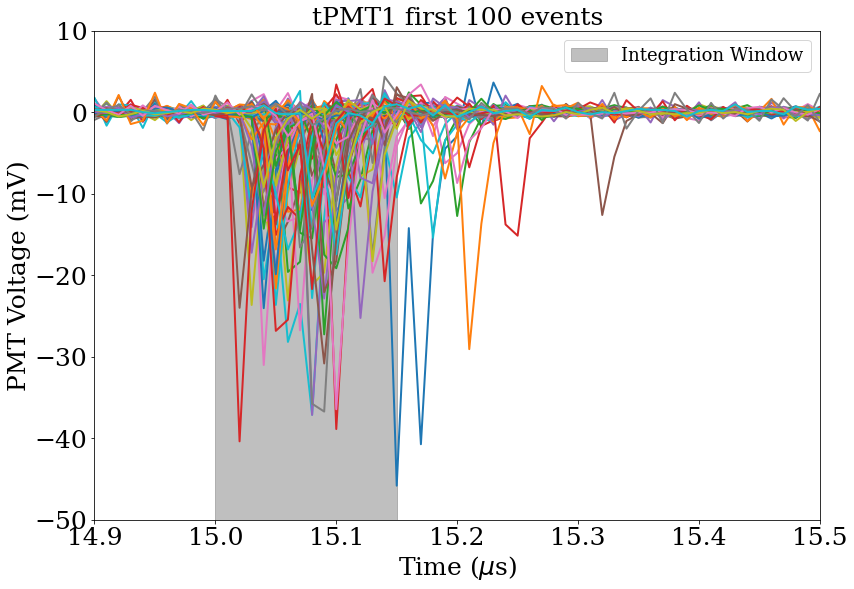

CPU times: user 515 ms, sys: 6.01 ms, total: 521 ms
Wall time: 534 ms


In [203]:
%%time

plt.figure()
for i in range(0,100):
    plt.plot(np.arange(0, 3000, 1)/100, adj_tPMT1[i]*adcTomV, linewidth = 2)
rect = Rectangle((15, -50), 0.15, 50, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-50, 10])
plt.legend(fontsize = 18)
plt.title("tPMT1 first 100 events")
plt.show()

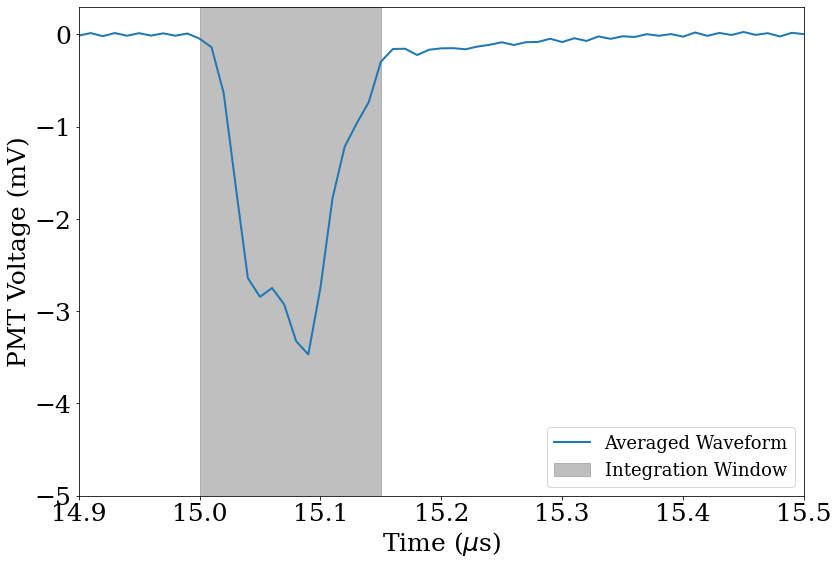

CPU times: user 122 ms, sys: 1.99 ms, total: 124 ms
Wall time: 128 ms


In [202]:
%%time

plt.figure()
plt.plot(np.arange(0, 3000, 1)/100, merged_tPMT1*adcTomV, linewidth = 2, label = 'Averaged Waveform')
rect = Rectangle((15, -20), 0.15, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 0.3])
plt.legend(fontsize = 18)
plt.show()

### Analysis

In [204]:
%%time

start, stop, channel = 1500, 1515, 1
areas_tPMT1, heights_tPMT1, offsets_tPMT1 = MiXHelper.LED_simple(friday1040names, start, stop, channel)

areas_tPMT1 = np.array(areas_tPMT1)
heights_tPMT1 = np.array(heights_tPMT1)
offsets_tPMT1 = np.array(offsets_tPMT1)

CPU times: user 1min, sys: 13.5 s, total: 1min 13s
Wall time: 2min 13s


In [205]:
%%time

trapzAreas_tPMT1 = trapzArea(friday1040names, start, stop, channel)
trapzAreas_tPMT1 = np.array(trapzAreas_tPMT1)

CPU times: user 1min 4s, sys: 13.2 s, total: 1min 17s
Wall time: 1min 18s


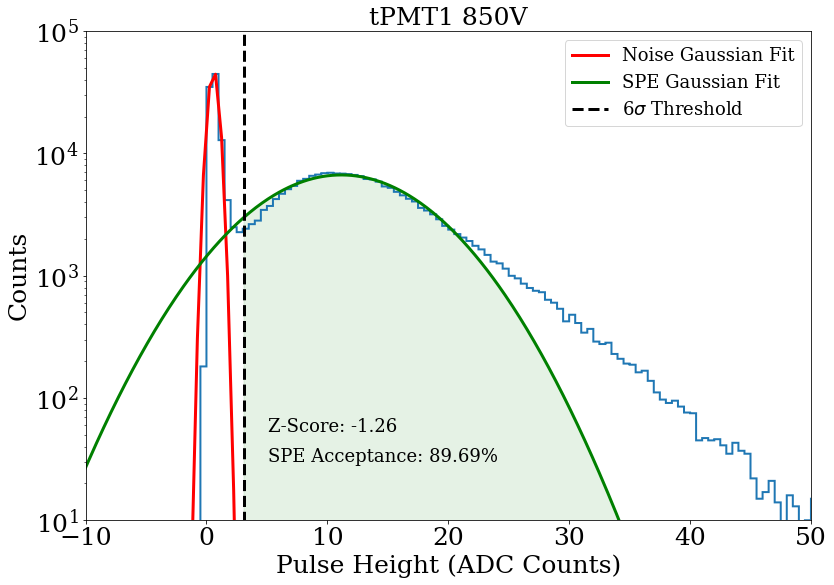

CPU times: user 343 ms, sys: 8.99 ms, total: 352 ms
Wall time: 367 ms


In [206]:
%%time

plt.figure()
height_n, height_raw_bins, patches = plt.hist(heights_tPMT1/10, bins = np.arange(-55, 250, 0.5), histtype = 'step', log = True, linewidth = 2)

height_bins = height_raw_bins[:-1]
x = height_bins[(height_bins >= 0) & (height_bins <= 5)] + 0.5/2
y = height_n[(height_bins >= 0) & (height_bins <= 5)]
p0 = [1e5, 0, 20]
coeff, var_matrix = curve_fit(MiXHelper.gaussian, x, y, p0=p0, maxfev = 10000)
cut_pos = np.abs(6*coeff[2]) + coeff[1]
hist_fit = MiXHelper.gaussian(height_bins + 0.5/2, *coeff)
plt.plot(height_bins + 0.5/2, hist_fit, color = 'r', linewidth = 3, label = 'Noise Gaussian Fit')

x2 = height_bins[(height_bins >= 5) & (height_bins <= 25)] + 0.5/2
y2 = height_n[(height_bins >= 5) & (height_bins <= 25)]
p2 = [2e3, 17, 2]
coeff2, var_matrix2 = curve_fit(MiXHelper.gaussian, x2, y2, p0=p2, maxfev = 10000)
x_fit2 = np.arange(-15, 80, 0.1)
hist_fit2 = MiXHelper.gaussian(x_fit2, *coeff2)
plt.plot(x_fit2, hist_fit2, color = 'g', linewidth = 3, label = 'SPE Gaussian Fit')
plt.fill_between(x_fit2[x_fit2 >= cut_pos], hist_fit2[x_fit2 >= cut_pos], color = 'green', alpha = 0.1)

zScore = (cut_pos - coeff2[1])/coeff2[2]
prob = 1 - scipy.stats.norm.cdf(zScore)
plt.text(cut_pos + 2, 5.3e1, 'Z-Score: ' + str(round(zScore, 2)), fontsize = 18)
plt.text(cut_pos + 2, 3e1, 'SPE Acceptance: ' + str(round(prob*100, 2)) + '%', fontsize = 18)

plt.plot([cut_pos, cut_pos], [1, 4e5], 'k--', linewidth = 3, label = '6$\sigma$ Threshold')

plt.xlim([-10, 50])
plt.ylim([1e1, 1e5])
plt.xlabel('Pulse Height (ADC Counts)')
plt.ylabel('Counts')
plt.title('tPMT1 850V')
plt.legend(fontsize = 18)
plt.show()

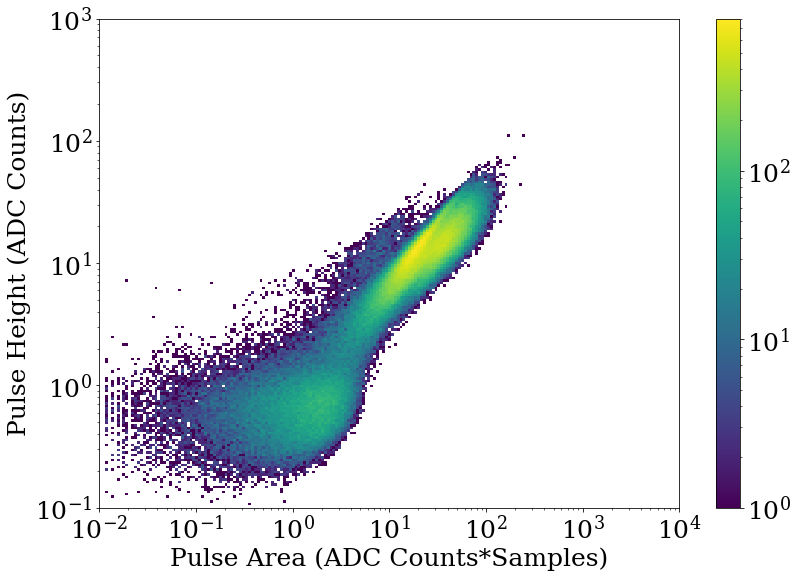

CPU times: user 699 ms, sys: 9.06 ms, total: 708 ms
Wall time: 725 ms


In [207]:
%%time

bins = 200
xbins = np.logspace(-2, 4, bins)
ybins = np.logspace(-1, 3, bins)

fig, ax = plt.subplots()
h = ax.hist2d(trapzAreas_tPMT1/10, heights_tPMT1/10, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Area (ADC Counts*Samples)')
plt.ylabel('Pulse Height (ADC Counts)')
fig.colorbar(h[3], ax = ax)
plt.show()

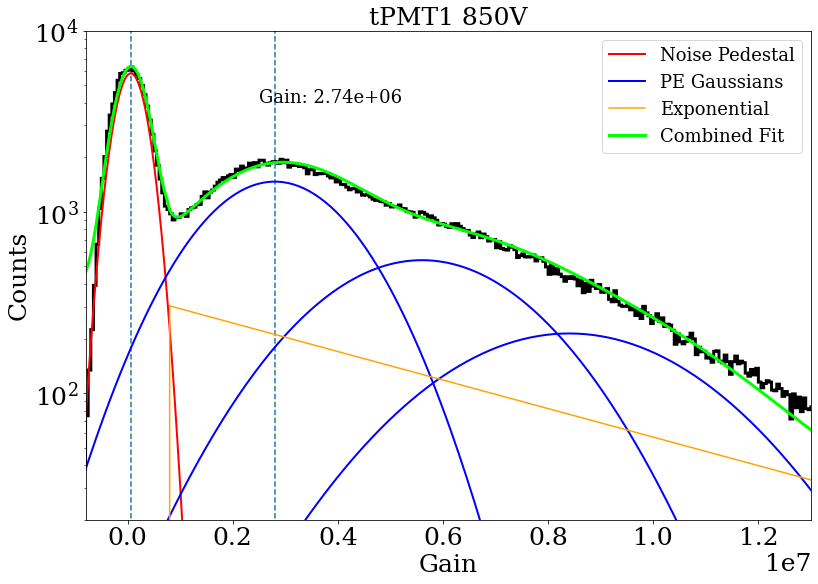

CPU times: user 491 ms, sys: 4.49 ms, total: 496 ms
Wall time: 553 ms


In [348]:
%%time

gains_tPMT1 = np.array(trapzAreas_tPMT1)*areaToGain / 10
n_tPMT1, raw_bins_tPMT1, patches = plt.hist(gains_tPMT1, bins = np.arange(-1e7, 4e7, 0.5e5), histtype = 'step', color = 'k', log = True, linewidth = 3)

bins_tPMT1 = raw_bins_tPMT1[:-1] + (2e5)/2
x = bins_tPMT1[(bins_tPMT1 > -3e6) & (bins_tPMT1 <= 2.5e7)]
y = n_tPMT1[(bins_tPMT1 > -3e6) & (bins_tPMT1 <= 2.5e7)]

p = np.inf
#bounds bc curve fit throws a fit otherwise. and it likes to give negative parameters
#          0  1  2  3  0   1  0  1  A      T
bounds = [(0, 0, 0, 0, -p, 2.8e6, 0, 0, 3.5e2, 1e-10),
          (p, p, p, p, 6e4, p, p, p, p, p)]

expStart = 7.5e5
p0 = [6.4e3, 1e3, 7e2, 2e2, 5e4, 2.8e6, 3.2e5, 1.3e6, 4e2, 1e-8]
#2e3, 8e2, 3e2
coeff, var_matrix = curve_fit(gaussian_4Exp, x, y, p0 = p0, bounds = bounds, maxfev = 100000)
hist_fit = gaussian_4Exp(bins_tPMT1, *coeff)

x_0 = bins_tPMT1[(bins_tPMT1 > -5e6) & (bins_tPMT1 <= 5e6)]
x_1 = bins_tPMT1[(bins_tPMT1 > -5e6) & (bins_tPMT1 <= 2e7)]
x_2 = bins_tPMT1[(bins_tPMT1 > 0) & (bins_tPMT1 <= 3e7)]
x_3 = bins_tPMT1[(bins_tPMT1 > 0) & (bins_tPMT1 <= 8e7)]

p_0 = [coeff[0], coeff[4], coeff[6]]
p_1 = [coeff[1], coeff[5], coeff[7]] #1.9e3, 2.8e6
p_2 = [coeff[2], 2*coeff[5], np.sqrt(2)*coeff[7]]
p_3 = [coeff[3], 3*coeff[5], np.sqrt(3)*coeff[7]]

plt.plot(x_0, MiXHelper.gaussian(x_0, *p_0), color = 'red', linewidth = 2, label = 'Noise Pedestal')
plt.plot(x_1, MiXHelper.gaussian(x_1, *p_1), color = 'blue', linewidth = 2, label = 'PE Gaussians')
plt.plot(x_2, MiXHelper.gaussian(x_2, *p_2), color = 'blue', linewidth = 2)
plt.plot(x_3, MiXHelper.gaussian(x_3, *p_3), color = 'blue', linewidth = 2)
plt.plot(bins_tPMT1, coeff[-2]*np.exp(-np.where(bins_tPMT1 > expStart, bins_tPMT1, 0)*coeff[-1])*[bins_tPMT1 > expStart][0], label='Exponential', color='orange')

plt.plot(bins_tPMT1, hist_fit, color = 'lime', linewidth = 3, label = 'Combined Fit')

plt.vlines(coeff[5], 0, 1e4, linestyles='dashed')
plt.vlines(coeff[4], 0, 1e4, linestyles='dashed')

gain = coeff[5] - coeff[4]
plt.text(0.25e7, 4e3, 'Gain: ' + str('{:.2e}'.format(gain)), fontsize = 18)

plt.xlim([-0.8e6, 1.3e7])
plt.ylim([2e1, 1e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('tPMT1 850V')
plt.legend(fontsize = 18)
plt.show()

In [349]:
p0, coeff

([6400.0,
  1000.0,
  700.0,
  200.0,
  50000.0,
  2800000.0,
  320000.0,
  1300000.0,
  400.0,
  1e-08],
 array([5.81678125e+03, 1.46809517e+03, 5.41110272e+02, 2.13311487e+02,
        6.00000000e+04, 2.80000000e+06, 2.90324024e+05, 1.33132800e+06,
        3.50000000e+02, 1.81186541e-07]))

# tPMT2 850V

### Visualization

In [15]:
%%time

tPMT2 = friday1040file['Channel2/ADCValues'].array()
adj_tPMT2 = tPMT2 - np.average(np.array(tPMT2[:, 0:100]), axis = 1)
merged_tPMT2 = np.average(np.array(adj_tPMT2), axis = 0)

CPU times: user 840 ms, sys: 559 ms, total: 1.4 s
Wall time: 3.17 s


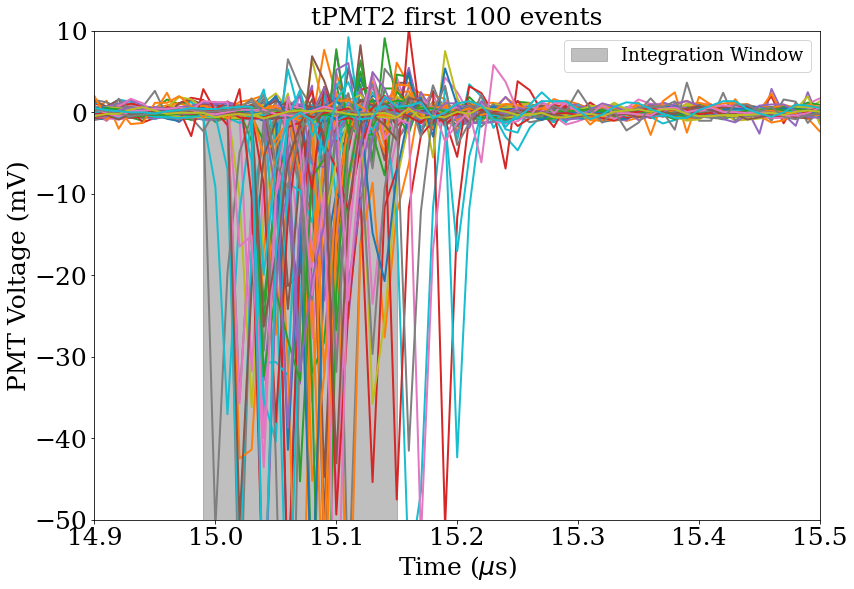

CPU times: user 488 ms, sys: 11.8 ms, total: 500 ms
Wall time: 519 ms


In [25]:
%%time

plt.figure()
for i in range(0,100):
    plt.plot(np.arange(0, 3000, 1)/100, adj_tPMT2[i]*adcTomV, linewidth = 2)
rect = Rectangle((14.99, -50), 0.16, 50, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-50, 10])
plt.legend(fontsize = 18)
plt.title("tPMT2 first 100 events")
plt.show()

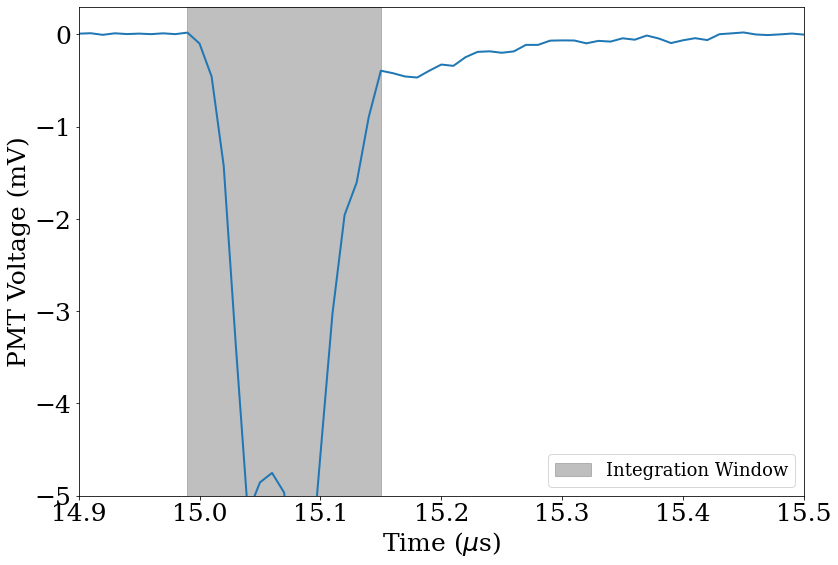

CPU times: user 132 ms, sys: 1.54 ms, total: 133 ms
Wall time: 140 ms


In [24]:
%%time

plt.figure()
plt.plot(np.arange(0, 3000, 1)/100, merged_tPMT2*adcTomV, linewidth = 2)
rect = Rectangle((14.99, -20), 0.16, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 0.3])
plt.legend(fontsize = 18)
plt.show()

### Analysis

In [26]:
%%time

start, stop, channel = 1499, 1515, 2
areas_tPMT2, heights_tPMT2, offsets_tPMT2 = MiXHelper.LED_simple(friday1040names, start, stop, channel)

areas_tPMT2 = np.array(areas_tPMT2)
heights_tPMT2 = np.array(heights_tPMT2)
offsets_tPMT2 = np.array(offsets_tPMT2)

CPU times: user 1min 1s, sys: 13.9 s, total: 1min 15s
Wall time: 2min 3s


In [27]:
%%time

trapzAreas_tPMT2 = trapzArea(friday1040names, start, stop, channel)
trapzAreas_tPMT2 = np.array(trapzAreas_tPMT2)

CPU times: user 1min 4s, sys: 13.6 s, total: 1min 18s
Wall time: 1min 20s


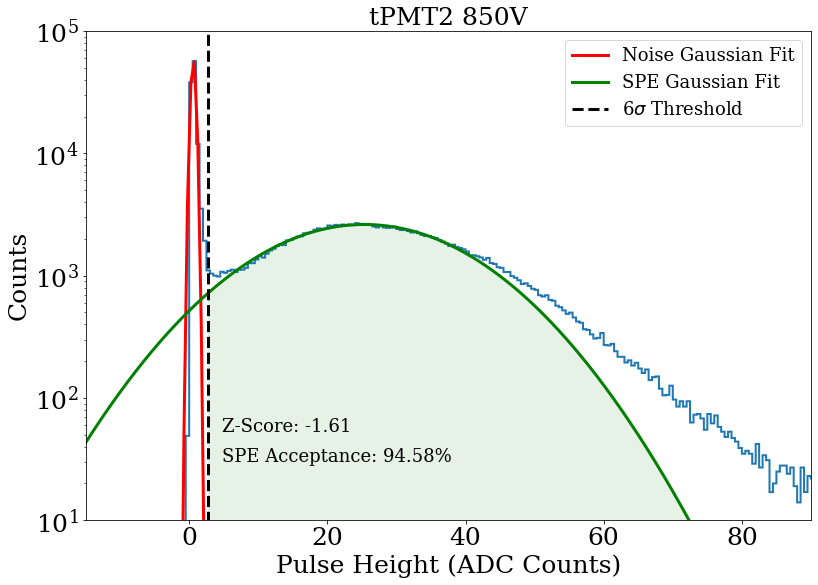

CPU times: user 333 ms, sys: 3.85 ms, total: 337 ms
Wall time: 344 ms


In [107]:
%%time

plt.figure()
height_n, height_raw_bins, patches = plt.hist(heights_tPMT2/10, bins = np.arange(-55, 250, 0.5), histtype = 'step', log = True, linewidth = 2)

height_bins = height_raw_bins[:-1]
x = height_bins[(height_bins >= 0) & (height_bins <= 5)] + 0.5/2
y = height_n[(height_bins >= 0) & (height_bins <= 5)]
p0 = [1e5, 0, 20]
coeff, var_matrix = curve_fit(MiXHelper.gaussian, x, y, p0=p0, maxfev=10000)
cut_pos = np.abs(6*coeff[2]) + coeff[1]
hist_fit = MiXHelper.gaussian(height_bins + 0.5/2, *coeff)
plt.plot(height_bins + 0.5/2, hist_fit, color = 'r', linewidth = 3, label = 'Noise Gaussian Fit')

x2 = height_bins[(height_bins >= 10) & (height_bins <= 40)] + 0.5/2
y2 = height_n[(height_bins >= 10) & (height_bins <= 40)]
p2 = [2e3, 17, 2]
coeff2, var_matrix2 = curve_fit(MiXHelper.gaussian, x2, y2, p0=p2, maxfev=1000000)
x_fit2 = np.arange(-15, 80, 0.1)
hist_fit2 = MiXHelper.gaussian(x_fit2, *coeff2)
plt.plot(x_fit2, hist_fit2, color = 'g', linewidth = 3, label = 'SPE Gaussian Fit')
plt.fill_between(x_fit2[x_fit2 >= cut_pos], hist_fit2[x_fit2 >= cut_pos], color = 'green', alpha = 0.1)

zScore = (cut_pos - coeff2[1])/coeff2[2]
prob = 1 - scipy.stats.norm.cdf(zScore)
plt.text(cut_pos + 2, 5.3e1, 'Z-Score: ' + str(round(zScore, 2)), fontsize = 18)
plt.text(cut_pos + 2, 3e1, 'SPE Acceptance: ' + str(round(prob*100, 2)) + '%', fontsize = 18)

plt.plot([cut_pos, cut_pos], [1, 4e5], 'k--', linewidth = 3, label = '6$\sigma$ Threshold')

plt.xlim([-15, 90])
plt.ylim([1e1, 1e5])
plt.xlabel('Pulse Height (ADC Counts)')
plt.ylabel('Counts')
plt.title('tPMT2 850V')
plt.legend(fontsize = 18)
plt.show()

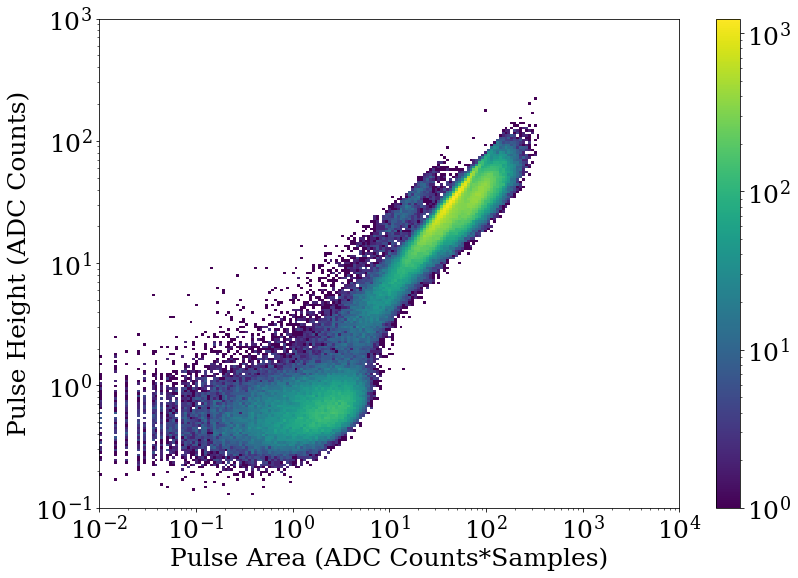

CPU times: user 622 ms, sys: 1.78 ms, total: 624 ms
Wall time: 636 ms


In [109]:
%%time

bins = 200
xbins = np.logspace(-2, 4, bins)
ybins = np.logspace(-1, 3, bins)

fig, ax = plt.subplots()
h = ax.hist2d(trapzAreas_tPMT2/10, heights_tPMT2/10, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Area (ADC Counts*Samples)')
plt.ylabel('Pulse Height (ADC Counts)')
fig.colorbar(h[3], ax = ax)
plt.show()

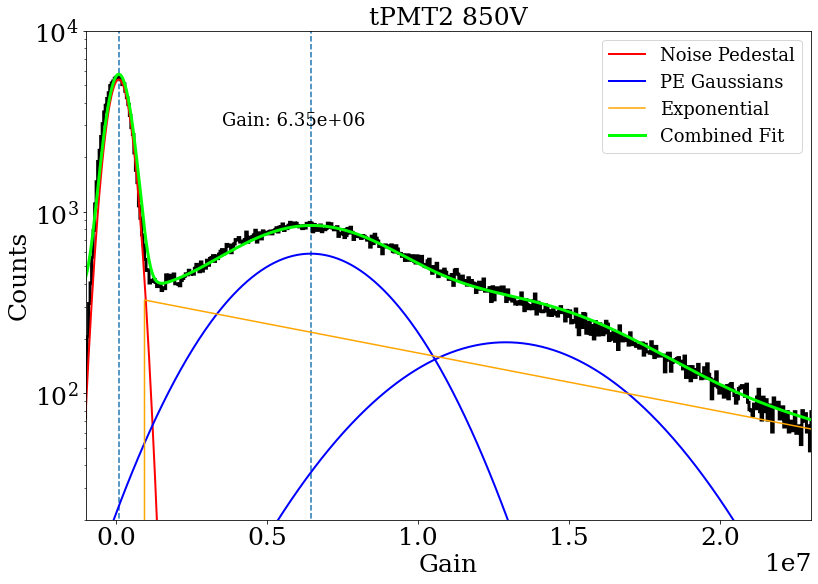

CPU times: user 498 ms, sys: 1.66 ms, total: 500 ms
Wall time: 556 ms


In [392]:
%%time

gains_tPMT2 = np.array(trapzAreas_tPMT2)*areaToGain / 10
n_tPMT2, raw_bins_tPMT2, patches = plt.hist(gains_tPMT2, bins = np.arange(-1e7, 4e7, 0.5e5), histtype = 'step', color = 'k', log = True, linewidth = 3)

bins_tPMT2 = raw_bins_tPMT2[:-1] + (2e5)/2
x = bins_tPMT2[(bins_tPMT2 > -3e6) & (bins_tPMT2 <= 2.5e7)]
y = n_tPMT2[(bins_tPMT2 > -3e6) & (bins_tPMT2 <= 2.5e7)]
p0 = [5.5e3, 8e2, 3e2, 5e1, 0, 5.8e6, 1.15e6, 3.7e6, 4e2, 1e-7, 9e5]

p = np.inf
#          0  1  2  3  0  1  0  1  A  T
bounds = [(0, 0, 0, 0, 0, 0, 0, 0, 3.5e2, 1e-10, 5e5),
          (p, p, p, p, 1e5, p, p, p, p, p, 2e6)]

coeff, var_matrix = curve_fit(gaussian_4Exp_expStart, x, y, p0 = p0, bounds=bounds, maxfev = 10000)
hist_fit = gaussian_4Exp_expStart(bins_tPMT2, *coeff)

x_0 = bins_tPMT2[(bins_tPMT2 > -5e6) & (bins_tPMT2 <= 5e6)]
x_1 = bins_tPMT2[(bins_tPMT2 > -5e6) & (bins_tPMT2 <= 2e7)]
x_2 = bins_tPMT2[(bins_tPMT2 > 0) & (bins_tPMT2 <= 3e7)]
x_3 = bins_tPMT2[(bins_tPMT2 > 0) & (bins_tPMT2 <= 8e7)]
p_0 = [coeff[0], coeff[4], coeff[6]]
p_1 = [coeff[1], coeff[5], coeff[7]]
p_2 = [coeff[2], 2*coeff[5], np.sqrt(2)*coeff[7]]
p_3 = [coeff[3], 3*coeff[5], np.sqrt(3)*coeff[7]]

plt.plot(x_0, MiXHelper.gaussian(x_0, *p_0), color = 'red', linewidth = 2, label = 'Noise Pedestal')
plt.plot(x_1, MiXHelper.gaussian(x_1, *p_1), color = 'blue', linewidth = 2, label = 'PE Gaussians')
plt.plot(x_2, MiXHelper.gaussian(x_2, *p_2), color = 'blue', linewidth = 2)
plt.plot(x_3, MiXHelper.gaussian(x_3, *p_3), color = 'blue', linewidth = 2)
plt.plot(bins_tPMT2, coeff[-3]*np.exp(-np.where(bins_tPMT2 > coeff[-1], bins_tPMT2, 0)*coeff[-2])*[bins_tPMT2 > coeff[-1]][0], label='Exponential', color='orange')

plt.plot(bins_tPMT2, hist_fit, color = 'lime', linewidth = 3, label = 'Combined Fit')

plt.vlines(coeff[5], 0, 1e4, linestyles='dashed')
plt.vlines(coeff[4], 0, 1e4, linestyles='dashed')

gain = coeff[5] - coeff[4]
plt.text(0.35e7, 3e3, 'Gain: ' + str('{:.2e}'.format(gain)), fontsize = 18)

plt.xlim([-1e6, 2.3e7])
plt.ylim([2e1, 1e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('tPMT2 850V')
plt.legend(fontsize = 18)
plt.show()

In [393]:
p0, coeff

([5500.0,
  800.0,
  300.0,
  50.0,
  0,
  5800000.0,
  1150000.0,
  3700000.0,
  400.0,
  1e-07,
  900000.0],
 array([5.37610151e+03, 5.87769111e+02, 1.90686307e+02, 6.55365794e+00,
        1.00000000e+05, 6.45031761e+06, 3.76953061e+05, 2.50727752e+06,
        3.50000750e+02, 7.42855983e-08, 9.00000000e+05]))

## tPMT3 850V

### Visualization

In [93]:
%%time

tPMT3 = friday1040file['Channel3/ADCValues'].array()
adj_tPMT3 = tPMT3 - np.average(np.array(tPMT3[:, 0:100]), axis = 1)
merged_tPMT3 = np.average(np.array(adj_tPMT3), axis = 0)

CPU times: user 822 ms, sys: 512 ms, total: 1.33 s
Wall time: 2.72 s


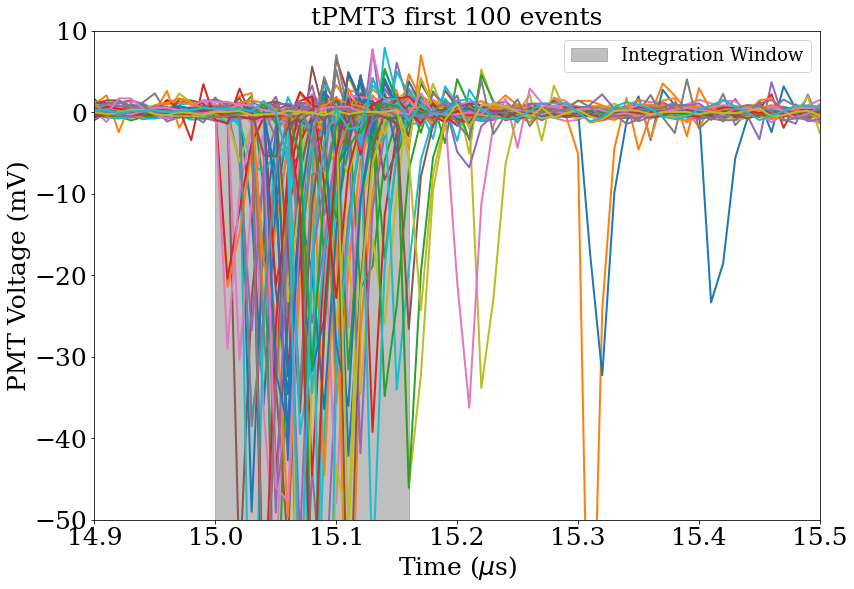

CPU times: user 440 ms, sys: 4.86 ms, total: 445 ms
Wall time: 461 ms


In [103]:
%%time

plt.figure()
for i in range(0,100):
    plt.plot(np.arange(0, 3000, 1)/100, adj_tPMT3[i]*adcTomV, linewidth = 2)
rect = Rectangle((15, -50), 0.16, 50, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-50, 10])
plt.legend(fontsize = 18)
plt.title("tPMT3 first 100 events")
plt.show()

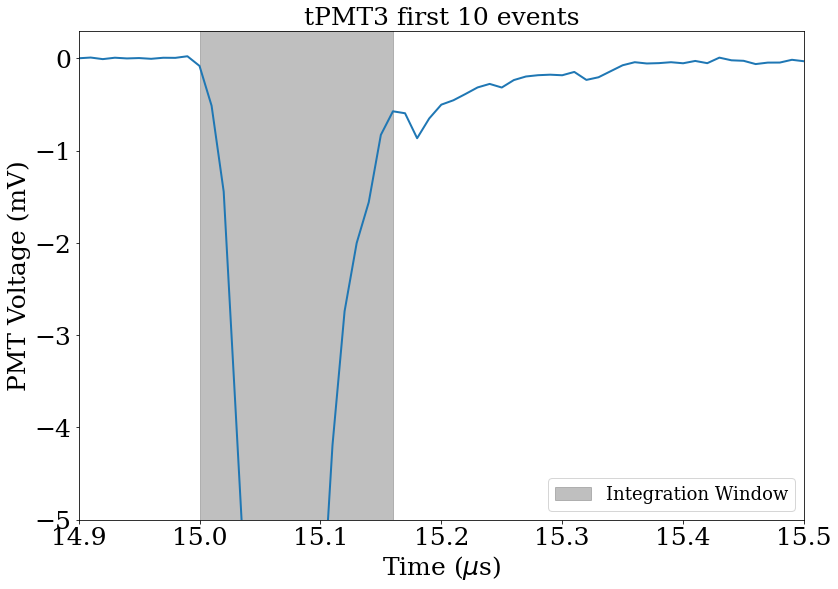

CPU times: user 122 ms, sys: 950 µs, total: 123 ms
Wall time: 129 ms


In [101]:
%%time

plt.figure()
plt.plot(np.arange(0, 3000, 1)/100, merged_tPMT3*adcTomV, linewidth = 2)
rect = Rectangle((15, -20), 0.16, 40, alpha = 0.5, color = 'grey', label = 'Integration Window')
plt.gca().add_patch(rect)
plt.xlabel('Time ($\mu$s)')
plt.ylabel('PMT Voltage (mV)')
plt.xlim([14.9, 15.5])
plt.ylim([-5, 0.3])
plt.legend(fontsize = 18)
plt.title("tPMT3 first 10 events")
plt.show()

### Analysis

In [102]:
%%time

start, stop, channel = 1500, 1516, 3
areas_tPMT3, heights_tPMT3, offsets_tPMT3 = MiXHelper.LED_simple(friday1040names, start, stop, channel)

areas_tPMT3 = np.array(areas_tPMT3)
heights_tPMT3 = np.array(heights_tPMT3)
offsets_tPMT3 = np.array(offsets_tPMT3)

CPU times: user 59.3 s, sys: 12.7 s, total: 1min 12s
Wall time: 1min 54s


In [104]:
%%time

trapzAreas_tPMT3 = trapzArea(friday1040names, start, stop, channel)
trapzAreas_tPMT3 = np.array(trapzAreas_tPMT3)

CPU times: user 1min 3s, sys: 12.5 s, total: 1min 16s
Wall time: 1min 17s


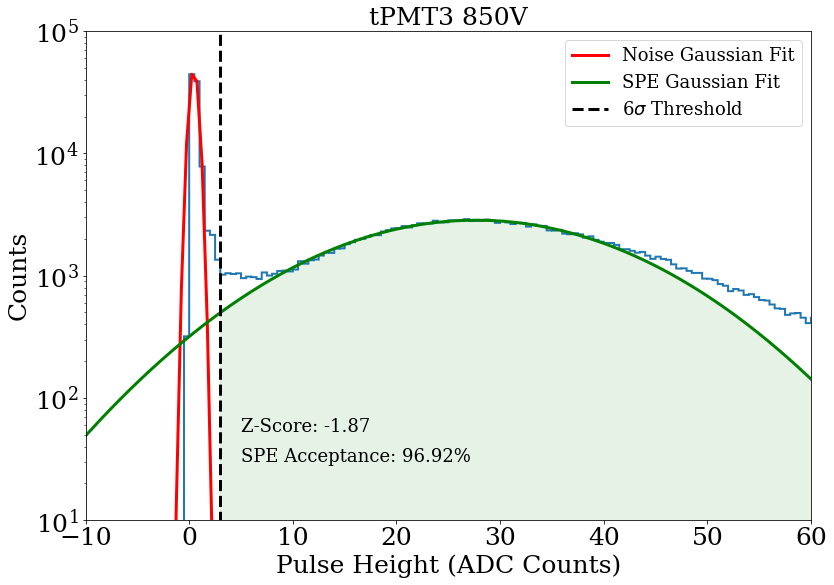

CPU times: user 344 ms, sys: 866 µs, total: 345 ms
Wall time: 352 ms


In [106]:
%%time

plt.figure()
height_n, height_raw_bins, patches = plt.hist(heights_tPMT3/10, bins = np.arange(-55, 250, 0.5), histtype = 'step', log = True, linewidth = 2)

height_bins = height_raw_bins[:-1]
x = height_bins[(height_bins >= 0) & (height_bins <= 5)] + 0.5/2
y = height_n[(height_bins >= 0) & (height_bins <= 5)]
p0 = [1e5, 0, 20]
coeff, var_matrix = curve_fit(MiXHelper.gaussian, x, y, p0=p0)
cut_pos = np.abs(6*coeff[2]) + coeff[1]
hist_fit = MiXHelper.gaussian(height_bins + 0.5/2, *coeff)
plt.plot(height_bins + 0.5/2, hist_fit, color = 'r', linewidth = 3, label = 'Noise Gaussian Fit')

x2 = height_bins[(height_bins >= 7) & (height_bins <= 30)] + 0.5/2
y2 = height_n[(height_bins >= 7) & (height_bins <= 30)]
p2 = [2e3, 22, 1.5]
coeff2, var_matrix2 = curve_fit(MiXHelper.gaussian, x2, y2, p0=p2)
x_fit2 = np.arange(-15, 80, 0.1)
hist_fit2 = MiXHelper.gaussian(x_fit2, *coeff2)
plt.plot(x_fit2, hist_fit2, color = 'g', linewidth = 3, label = 'SPE Gaussian Fit')
plt.fill_between(x_fit2[x_fit2 >= cut_pos], hist_fit2[x_fit2 >= cut_pos], color = 'green', alpha = 0.1)

zScore = (cut_pos - coeff2[1])/coeff2[2]
prob = 1 - scipy.stats.norm.cdf(zScore)
plt.text(cut_pos + 2, 5.3e1, 'Z-Score: ' + str(round(zScore, 2)), fontsize = 18)
plt.text(cut_pos + 2, 3e1, 'SPE Acceptance: ' + str(round(prob*100, 2)) + '%', fontsize = 18)

plt.plot([cut_pos, cut_pos], [1, 4e5], 'k--', linewidth = 3, label = '6$\sigma$ Threshold')

plt.xlim([-10, 60])
plt.ylim([1e1, 1e5])
plt.xlabel('Pulse Height (ADC Counts)')
plt.ylabel('Counts')
plt.title('tPMT3 850V')
plt.legend(fontsize = 18)
plt.show()

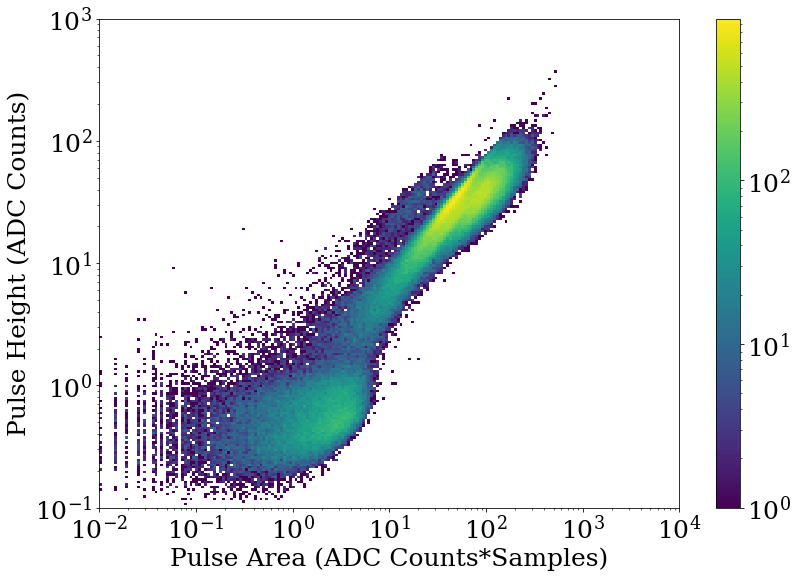

CPU times: user 702 ms, sys: 5.1 ms, total: 707 ms
Wall time: 723 ms


In [108]:
%%time

bins = 200
xbins = np.logspace(-2, 4, bins)
ybins = np.logspace(-1, 3, bins)

fig, ax = plt.subplots()
h = ax.hist2d(trapzAreas_tPMT3/10, heights_tPMT3/10, bins = [xbins, ybins], norm = mpl.colors.LogNorm(), cmap = 'viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Pulse Area (ADC Counts*Samples)')
plt.ylabel('Pulse Height (ADC Counts)')
fig.colorbar(h[3], ax = ax)
plt.show()

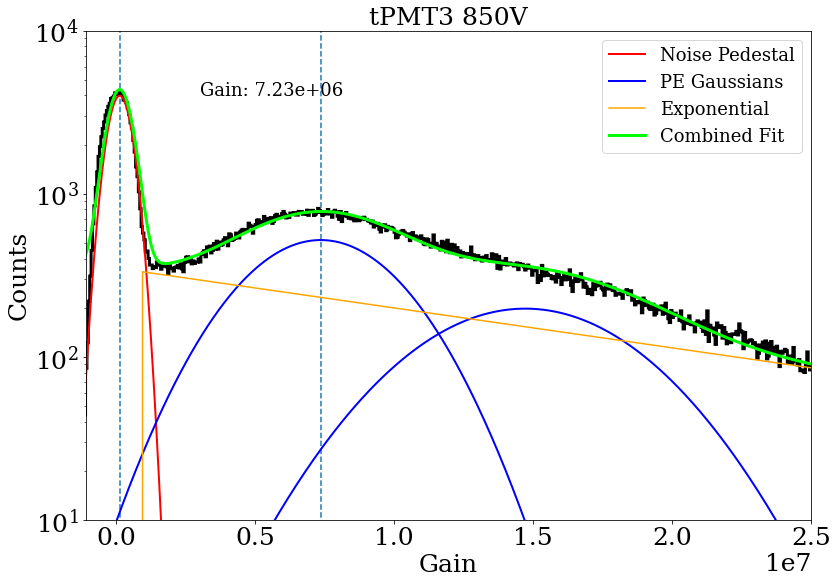

CPU times: user 786 ms, sys: 2.67 ms, total: 789 ms
Wall time: 830 ms


In [394]:
%%time

gains_tPMT3 = np.array(trapzAreas_tPMT3)*areaToGain / 10
n_tPMT3, raw_bins_tPMT3, patches = plt.hist(gains_tPMT3, bins = np.arange(-1e7, 4e7, 0.5e5), histtype = 'step', color = 'k', log = True, linewidth = 3)

bins_tPMT3 = raw_bins_tPMT3[:-1] + (2e5)/2
x = bins_tPMT3[(bins_tPMT3 > -3e6) & (bins_tPMT3 <= 2.5e7)]
y = n_tPMT3[(bins_tPMT3 > -3e6) & (bins_tPMT3 <= 2.5e7)]
p0 = [4.5e3, 8e2, 3e2, 1e2, 0, 6.7e6, 1.1e6, 3.8e6, 4e2, 1e-7, 0.9e6]

p = np.inf
#          0  1  2  3  0  1  0  1  A  T
bounds = [(0, 0, 0, 0, 0, 0, 0, 0, 3.5e2, 1e-10, 5e5),
          (p, p, p, p, p, p, p, p, p, p, 2e6)]

coeff, var_matrix = curve_fit(gaussian_4Exp_expStart, x, y, p0 = p0, bounds = bounds, maxfev = 10000)
hist_fit = gaussian_4Exp_expStart(bins_tPMT3, *coeff)

x_0 = bins_tPMT3[(bins_tPMT3 > -5e6) & (bins_tPMT3 <= 5e6)]
x_1 = bins_tPMT3[(bins_tPMT3 > -5e6) & (bins_tPMT3 <= 2e7)]
x_2 = bins_tPMT3[(bins_tPMT3 > 0) & (bins_tPMT3 <= 3e7)]
x_2 = bins_tPMT3[(bins_tPMT3 > 0) & (bins_tPMT3 <= 8e7)]

p_0 = [coeff[0], coeff[4], coeff[6]]
p_1 = [coeff[1], coeff[5], coeff[7]]
p_2 = [coeff[2], 2*coeff[5], np.sqrt(2)*coeff[7]]
p_3 = [coeff[3], 3*coeff[5], np.sqrt(3)*coeff[7]]

plt.plot(x_0, MiXHelper.gaussian(x_0, *p_0), color = 'red', linewidth = 2, label = 'Noise Pedestal')
plt.plot(x_1, MiXHelper.gaussian(x_1, *p_1), color = 'blue', linewidth = 2, label = 'PE Gaussians')
plt.plot(x_2, MiXHelper.gaussian(x_2, *p_2), color = 'blue', linewidth = 2)
plt.plot(x_3, MiXHelper.gaussian(x_3, *p_3), color = 'blue', linewidth = 2)
plt.plot(bins_tPMT3, coeff[-3]*np.exp(-np.where(bins_tPMT3 > coeff[-1], bins_tPMT3, 0)*coeff[-2])*[bins_tPMT3 > coeff[-1]][0], label='Exponential', color='orange')

plt.plot(bins_tPMT3, hist_fit, color = 'lime', linewidth = 3, label = 'Combined Fit')

plt.vlines(coeff[5], 0, 1e4, linestyles='dashed')
plt.vlines(coeff[4], 0, 1e4, linestyles='dashed')

gain = coeff[5] - coeff[4]
plt.text(0.3e7, 4e3, 'Gain: ' + str('{:.2e}'.format(gain)), fontsize = 18)

plt.xlim([-1.1e6, 2.5e7])
plt.ylim([1e1, 1e4])
plt.xlabel('Gain')
plt.ylabel('Counts')
plt.title('tPMT3 850V')
plt.legend(fontsize = 18)
plt.show()

In [395]:
p0, coeff

([4500.0,
  800.0,
  300.0,
  100.0,
  0,
  6700000.0,
  1100000.0,
  3800000.0,
  400.0,
  1e-07,
  900000.0],
 array([3.98794119e+03, 5.19362096e+02, 1.97185561e+02, 9.18227270e-01,
        1.27183387e+05, 7.36030288e+06, 4.30194248e+05, 2.60891542e+06,
        3.50000003e+02, 5.63647594e-08, 9.00000000e+05]))

#### SPE values from October 2022 (t0, t1, ... b): 7.25e6, 2.5e6, 5.9e6, 6.6e6, 1.75e7